In [1]:
from pathlib import Path
from cc_model.load_datasets import load_gt_dataset_cached


import graph_tool.all as gt
from cc_model.wl import WL, labelings_are_equivalent
from cc_model.fast_graph import FastGraph
import numpy as np
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
# Code that should make matplotlib use ACM font (libertine)
import matplotlib

rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    'figure.figsize': (5, 3),
    "text.usetex": True,
    'text.latex.preamble': 
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
matplotlib.rcParams.update(rc_fonts)

In [3]:
datasets = [#"karate", 
            "phonecalls",
            "HepPh", 
            "AstroPh", 
            "web-Google",
             "soc-Pokec"
#            "deezer_HR", "deezer_HU", "deezer_RO","tw_musae_DE",
#            "tw_musae_ENGB","tw_musae_FR","lastfm_asia","fb_ath",
#            "fb_pol", "facebook_sc"
           ]

In [4]:
dataset_path = Path("/home/felix/projects/colorful_configuration/datasets")

In [5]:
epsilon=1e-16
max_iter = 1200
alpha=0.85

In [6]:
def rewire_run_pagerank_for_round(G, depth, in_edges, number_of_rewires=10, verbosity=0):
    """ Calculate similarities in pagerank vectors for rewired G
    G :      FastGraph
    depth:    depth of WL iteration to be used
    in_base_pagerank :    in pagerank of G
    Generate synthethic networks which have the same WL colors as G
      at specific depth and return absolute error sum
    """
    pagerank_args = {"mode":"in",
                     "epsilon":epsilon,
                     "max_iter":max_iter,
                     "alpha":alpha,
                     "return_err":True}
    
    values = []
    for i in range(number_of_rewires):
        G.rewire(depth)
        rewired_edges = get_unique_edges(G)
        jaccard = calc_jaccard(in_edges, rewired_edges)
        

        values.append(jaccard)

    return values

In [7]:
def calc_jaccard(edges1, edges2):
    #assert edges1.shape[1]==1
    #assert edges2.shape[1]==1
    l1=len(edges1)
    l2=len(edges2)
    intersection = len(np.intersect1d(edges1, edges2))
    
    return intersection/(l1+l2-intersection)

In [8]:
def compute_on_all_datasets(n_rewires, verbosity=0):
    """ computes pagerank and compares it with rewired graphs
    """
    list_values = []
    for dataset in datasets:
        if verbosity > 0:
            print(dataset)
        G_base = load_gt_dataset_cached(dataset_path,
                                        dataset,
                                        verbosity=verbosity,
                                        force_reload=False)
        edges = np.array(G_base.get_edges(), dtype=np.uint32)


        
        G = FastGraph(edges, G_base.is_directed())

        values = get_SAE_for_iterations(G,
                                        n_rewires=n_rewires,)
        list_values.append(values)
    return list_values

In [9]:
def get_unique_edges(G):
    
    edges = np.array(G.edges, dtype=np.uint64).copy()
    if not G.is_directed:
        # need to "sort edges"
        edges2=np.empty_like(edges)
        edges2[:,0]=np.minimum(edges[:,0],edges[:,1])
        edges2[:,1]=np.maximum(edges[:,0],edges[:,1])
        edges=edges2
    return edges[:,0]*edges[:,1]

In [10]:
glob_pagerank=None
def get_SAE_for_iterations(G, n_rewires):
    values = []
    G.ensure_edges_prepared()
    
    base_edges = get_unique_edges(G)
    
    for WL_round in range(G.wl_iterations-1,-1,-1):
        if verbosity>0:
            print("WL round", WL_round)

        jaccard = rewire_run_pagerank_for_round(G,
                                             WL_round,
                                             base_edges,
                                             number_of_rewires=n_rewires,
                                             verbosity=0)
        values.append(jaccard)
    return values

In [11]:

verbosity=1
number_of_samples = 1
list_values = compute_on_all_datasets(number_of_samples, verbosity=1)

phonecalls
resetting
WL round 8
WL round 7
WL round 6
WL round 5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0
HepPh
resetting
WL round 7
WL round 6
WL round 5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0
AstroPh
resetting
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0
web-Google
resetting
WL round 28
WL round 27
WL round 26
WL round 25
WL round 24
WL round 23
WL round 22
WL round 21
WL round 20
WL round 19
WL round 18
WL round 17
WL round 16
WL round 15
WL round 14
WL round 13
WL round 12
WL round 11
WL round 10
WL round 9
WL round 8
WL round 7
WL round 6
WL round 5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0
soc-Pokec
resetting
WL round 7
WL round 6
WL round 5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0


In [12]:
print()
now = datetime.now()
if number_of_samples > 30:
    save_prefix = now.strftime("%Y_%m_%d__%H_%M_%S")
    out_name = "./results/"+"_jaccard_"+save_prefix+".pkl"
    print(out_name)
    with open(out_name, "wb") as f:
        pickle.dump((list_values, datasets), f)

In [13]:
def get_mean_std(list_values):
    list_means = []
    list_stds0 = []
    list_stds1 = []

    for values in list_values:
        mean = np.mean(values)+1e-20
        quantiles = np.quantile(values, [0.5-0.68/2, 0.5+0.68/2,])
        list_means.append(mean)
        list_stds0.append(quantiles[0])
        list_stds1.append(quantiles[1])
    list_means=np.array(list_means)
    list_means=list_means[::-1]
    list_stds = [np.abs(list_means-np.array(list_stds0[::-1])), np.abs(np.array(list_stds1[::-1])-list_means)]
    print(list_stds)
    return list_means, list_stds

def quickplot(list_values, datasets, show_alpha=False, save_date=None, xlim=None):
    plt.figure(figsize=(10,6))
    if show_alpha:
        x=np.linspace(0,15)
        y=2 *alpha**(x+1)
        plt.plot(x,y)
    
    markers = [".", "o", "<", "s", "*"]
    markers2 = ["^", "o", "+", "x", "_"]
    marker_sizes = 6*np.array([1.4, 1, 1.5, 1, 1.9,])
    


    for values, label, marker, ms in zip(list_values, datasets, markers2, marker_sizes):
        means, stds = get_mean_std(1-np.array(values))
        plt.errorbar(x=np.arange(len(means)),y=means, yerr=stds, label=label, fmt=marker+"--", markersize=ms)


    plt.ylabel("Diversity (1-Jaccard)")
    plt.xlabel("depth $d$")
    if xlim is not None:
        plt.xlim(*xlim)
    plt.yscale("log")
    plt.legend()
    #
    if save_date is None:
        plt.title("Convergence of pagerank for synthetic networks ")
    else:
        time_str = save_date.strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig(Path(".")/Path('images')/f'pagerank_{time_str}.pdf', bbox_inches = 'tight')

[array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.])]
[array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.])]


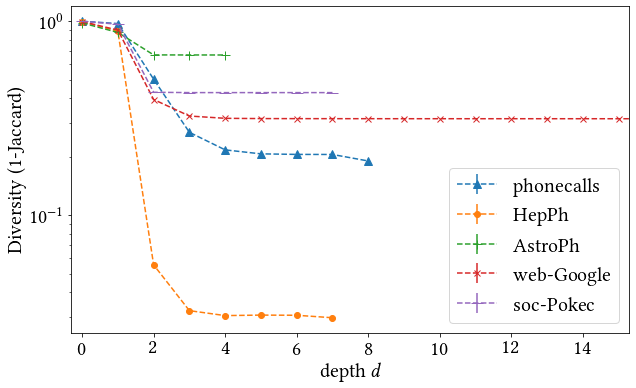

In [18]:
quickplot(list_values, datasets, show_alpha=False, save_date=datetime.now(), xlim=(-0.3,15.3))

In [15]:
load_dataset=True
if load_dataset:
    load_date = datetime(2021,12,11,3,2,49)
    save_prefix = load_date.strftime("%Y_%m_%d__%H_%M_%S")
    with open("./results/"+save_prefix+".pkl", "rb") as f:
        (list_means2, list_stds2, datasets2) = pickle.load(f)

[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.])]
[array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]
[array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]


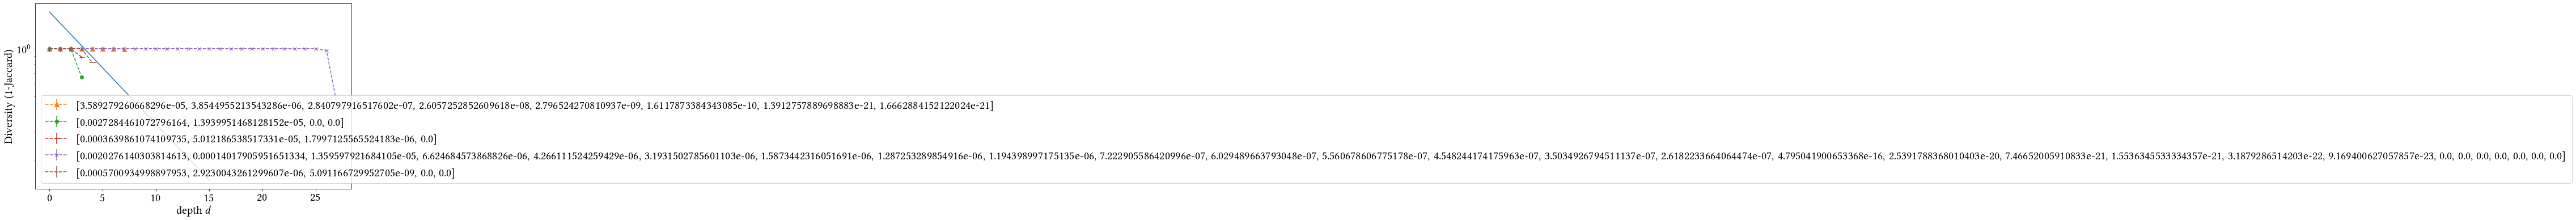

In [16]:
quickplot(list_means2, list_stds2, datasets2, save_date=load_date)

In [17]:
plt.rcParams['lines.markersize']

6.0